### Read data

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("assignment_rev2.csv.xls")

In [3]:
df.head(5)

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,...,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
0,42911697,47.0,14680.0,northern sub,567,200000,2005,1,apartment,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43018583,134.7,15502.0,northern sub,642,550000,1992,ground-floor,detached,5,...,False,True,False,True,True,False,False,True,False,True
2,39670968,71.0,9807.0,northern sub,320,500000,2009,ground-floor,detached,2,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,39740833,122.0,14682.0,northern sub,95,230000,2007,1,apartment,3,...,False,True,False,True,True,False,False,False,False,False
4,39742998,126.7,14682.0,northern sub,195,370000,2007,ground-floor,maisonette,4,...,False,True,False,True,True,False,False,False,False,True


We have in total 15447 data points

### ETL

**Replace/Remove NaN**

In [4]:
df.isnull().sum()

id                             0
ranking_score                  0
agent_id                     104
geography_name                 0
sq_meters                      0
price                          0
year_of_construction           0
floor                        732
subtype                        0
rooms                          0
no_of_bathrooms                0
energy_class               13340
renovation_year            13380
no_of_wc                       0
ad_type                        0
living_rooms                   0
kitchens                       0
balcony_area                   0
lux_home                    4238
new_development             3606
garage                      1630
furnished                   4169
preserved                   5433
investment                  4964
unfinished                  5420
equipped                   15447
heating_under_floor         4677
renovated                   4329
requires_renovation         4882
airy                        3518
bright    

In [5]:
# remove NAs from agent_id as this is information we want to have and only ~0.7% of the data will be dropped
df.dropna(axis = 0, subset = ["agent_id"], inplace = True)

# remove NAs from floor as this is information we want to have and only ~5% of the data will be dropped
df.dropna(axis = 0, subset = ["floor"], inplace = True)

# column equipped contains only NA values - so drop the entire column from df
df.drop(columns=['equipped'], inplace = True)

# column energy_class contains ~95% NA values - so drop the entire column from df
df.drop(columns=['energy_class'], inplace = True)

# ASSUMPTION: for values in binary columns, the NA is in reality a 0 - ie there is not such item in the property
# we will do this when cleaning the data types (look below)

# NA in renovation_year means that the property has not been renovated and this is important information so we will not change it
# however since we only have values for 14% of the data points, then will do some feature engineering later on - i.e. binary value: renovated 1/0

In total have dropped only ~5% of the data. Now we have 14614 data points.

**Clean data types**

In [6]:
# change agent_id and renovation_year from float to int
df['agent_id'] = df['agent_id'].astype('Int64')
df['renovation_year'] = df['renovation_year'].astype('Int64')

# change all object/boolean to int/binary
# ASSUMPTION: for values in binary columns, the NA is in reality a 0 - ie there is not such item in the property
for a in df.select_dtypes(include=object):
    try:
        df[a].replace({False: 0, True: 1}, inplace=True)
        df[a] = df[a].astype('Int64')
        df[a] = df[a].fillna(0)
    except:
        pass

**Feature Engineering**

In [7]:
df.renovation_year.unique()

<IntegerArray>
[<NA>, 2000, 2014, 1987, 2005, 2009, 1995, 2007, 2015, 2012, 2016, 2004, 2018,
 2013, 2008, 1980, 2010, 2017, 1996, 2011, 2001, 1977, 2002, 2006, 1988, 1999,
 2019, 1990, 2003, 1997, 1998, 1994, 1991, 1986, 1992, 1989, 1967, 1981, 1970,
 1960, 1975, 1976, 1973, 1985, 1982, 1950, 1983, 1993]
Length: 48, dtype: Int64

In [8]:
df['renovated'] = np.where(df['renovation_year'].isna()==True, 0, 1)
df.drop(columns=['renovation_year'], inplace=True)

**Deeper look into the highlighted variables mentioned in assignment**

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_19631/1585622511.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


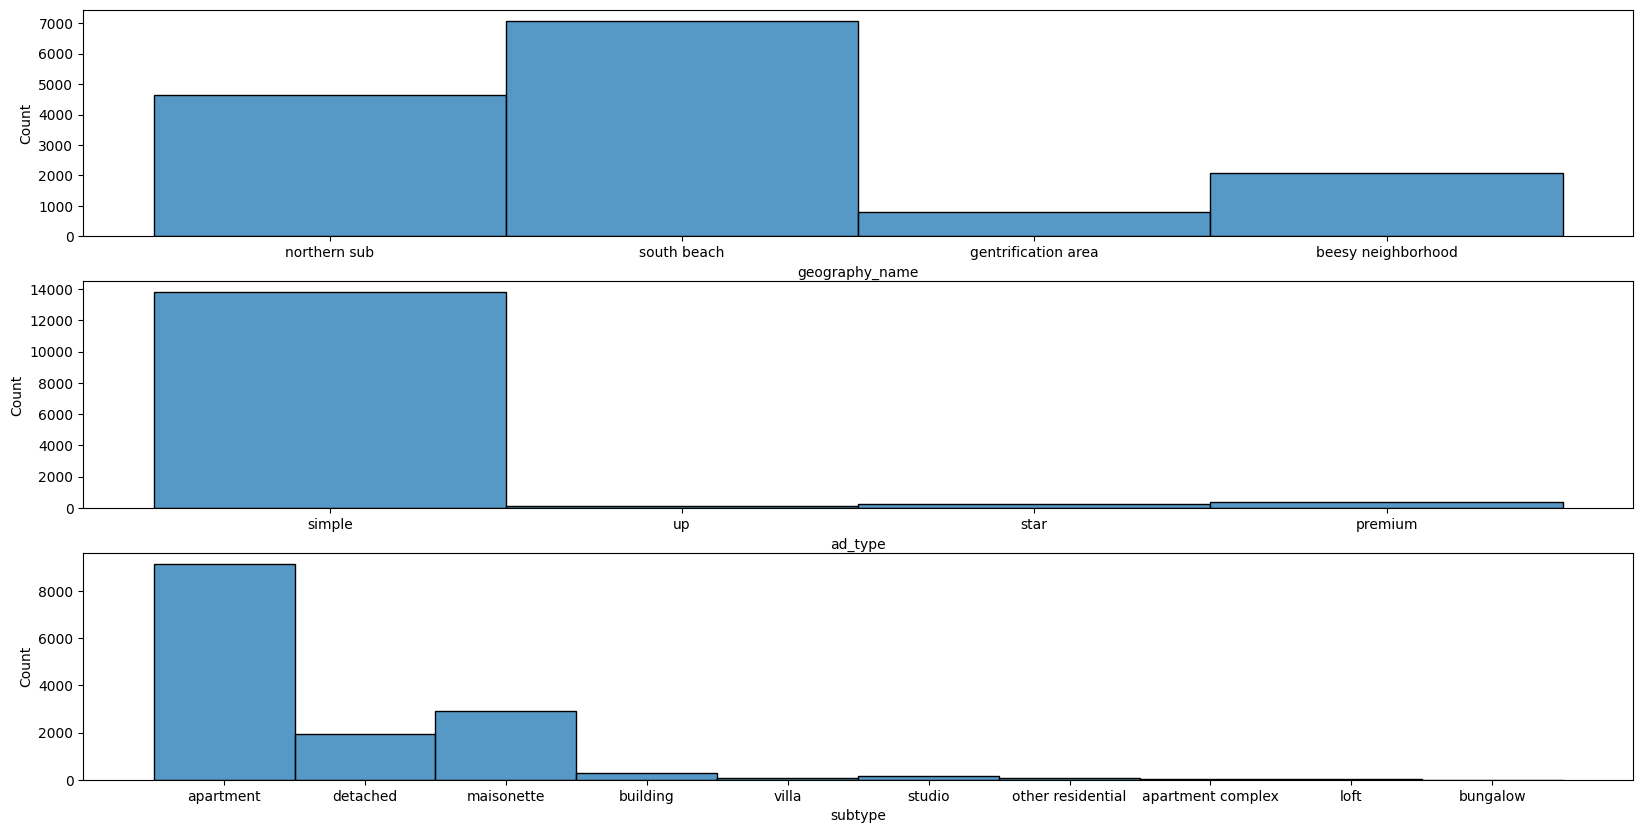

In [9]:
# Plot histograms for the categorical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['geography_name'], ax = ax[0])
sns.histplot(df['ad_type'], ax = ax[1])
sns.histplot(df['subtype'], ax = ax[2])
fig.show()

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_19631/2049019640.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


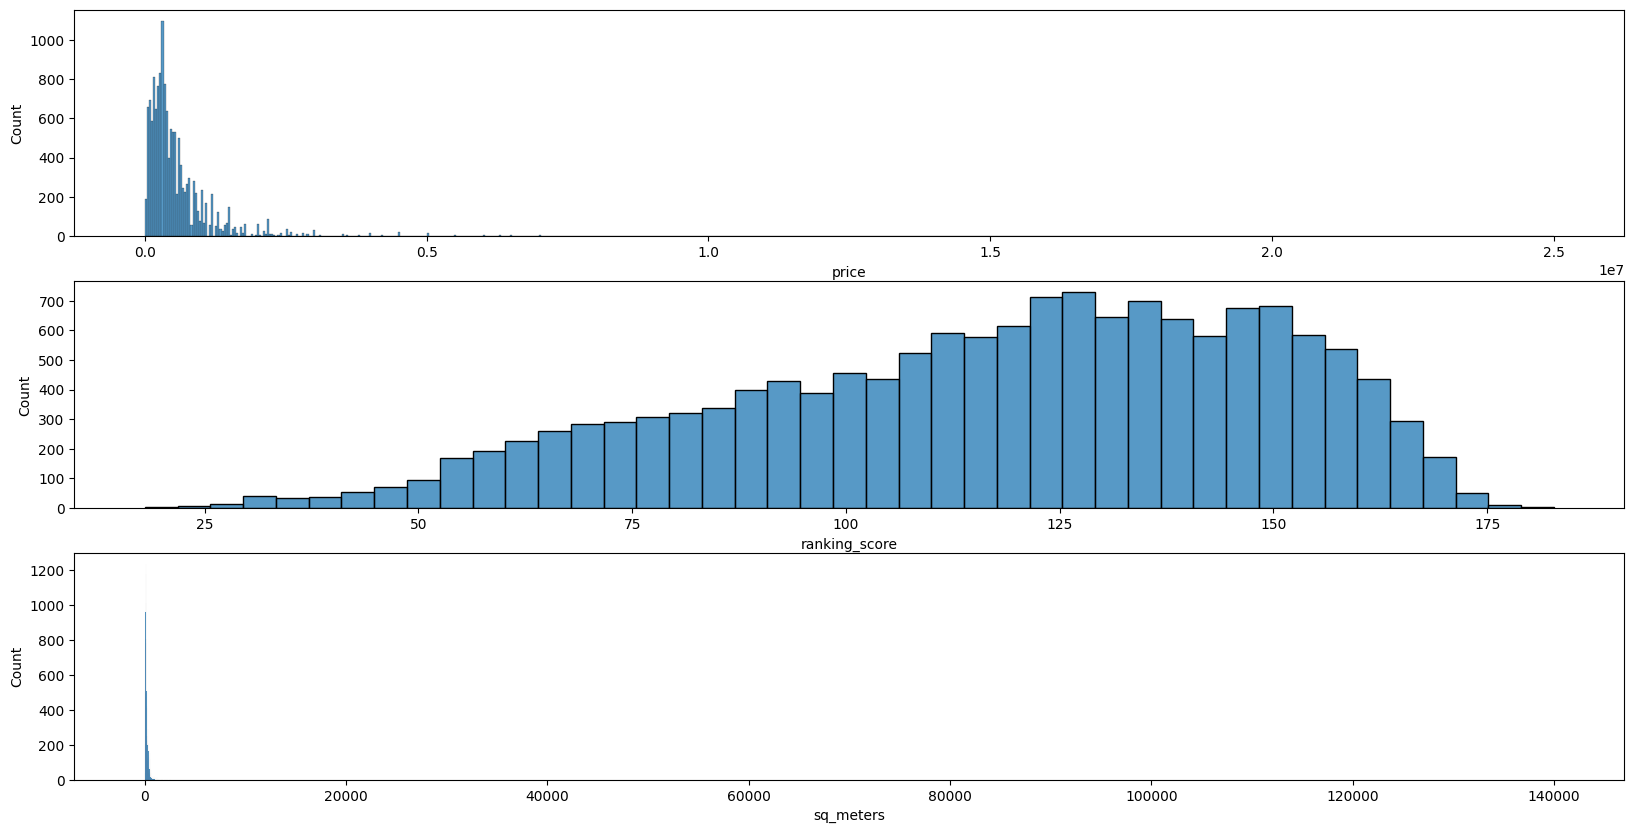

In [10]:
# Plot histograms for the numerical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['price'], ax = ax[0])
sns.histplot(df['ranking_score'], ax = ax[1])
sns.histplot(df['sq_meters'], ax = ax[2])
fig.show()

From the above histograms, we can clearly see that there are outliers in price and sq_meters which need to be treated

/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_19631/1251574918.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


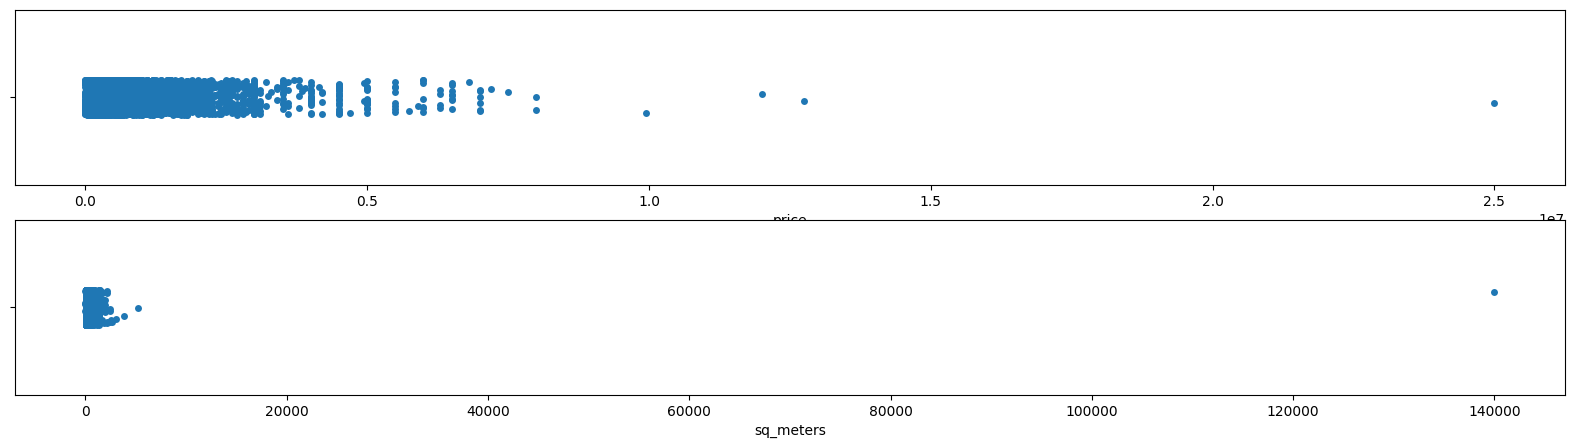

In [11]:
# plot for every numeric variable a stripplot to identify outliers

fig, ax = plt.subplots(2,1, figsize=(20,5))
sns.stripplot(df['price'], ax = ax[0], orient = 'h')
sns.stripplot(df['sq_meters'], ax = ax[1], orient = 'h')
fig.show()

**Remove outliers**

In [12]:
# remove outliers based on z-score

df = df[(np.abs(stats.zscore(df[['price', 'sq_meters']])) < 3).all(axis=1)]
df.reset_index(drop = True, inplace = True)
df

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,...,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
0,42911697,47.0,14680,northern sub,567,200000,2005,1,apartment,4,...,0,0,0,0,0,0,0,0,0,0
1,43018583,134.7,15502,northern sub,642,550000,1992,ground-floor,detached,5,...,0,1,0,1,1,0,0,1,0,1
2,39670968,71.0,9807,northern sub,320,500000,2009,ground-floor,detached,2,...,0,0,0,1,0,0,0,0,0,0
3,39740833,122.0,14682,northern sub,95,230000,2007,1,apartment,3,...,0,1,0,1,1,0,0,0,0,0
4,39742998,126.7,14682,northern sub,195,370000,2007,ground-floor,maisonette,4,...,0,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14387,43079210,101.0,19009,beesy neighborhood,80,75000,1960,3,apartment,2,...,0,0,0,0,0,0,0,0,0,0
14388,43079212,103.5,19009,beesy neighborhood,69,70000,1975,2,apartment,2,...,0,0,0,0,0,0,0,0,0,0
14389,43079508,118.1,6976,beesy neighborhood,75,120000,1974,3,apartment,1,...,0,1,0,0,0,0,0,0,0,0
14390,40498665,78.7,7354,beesy neighborhood,800,600000,1930,ground-floor,building,1,...,0,0,0,0,0,0,0,0,0,0


/var/folders/sf/x69fjdzx605fn55k8l21h2yc0000gn/T/ipykernel_19631/2049019640.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


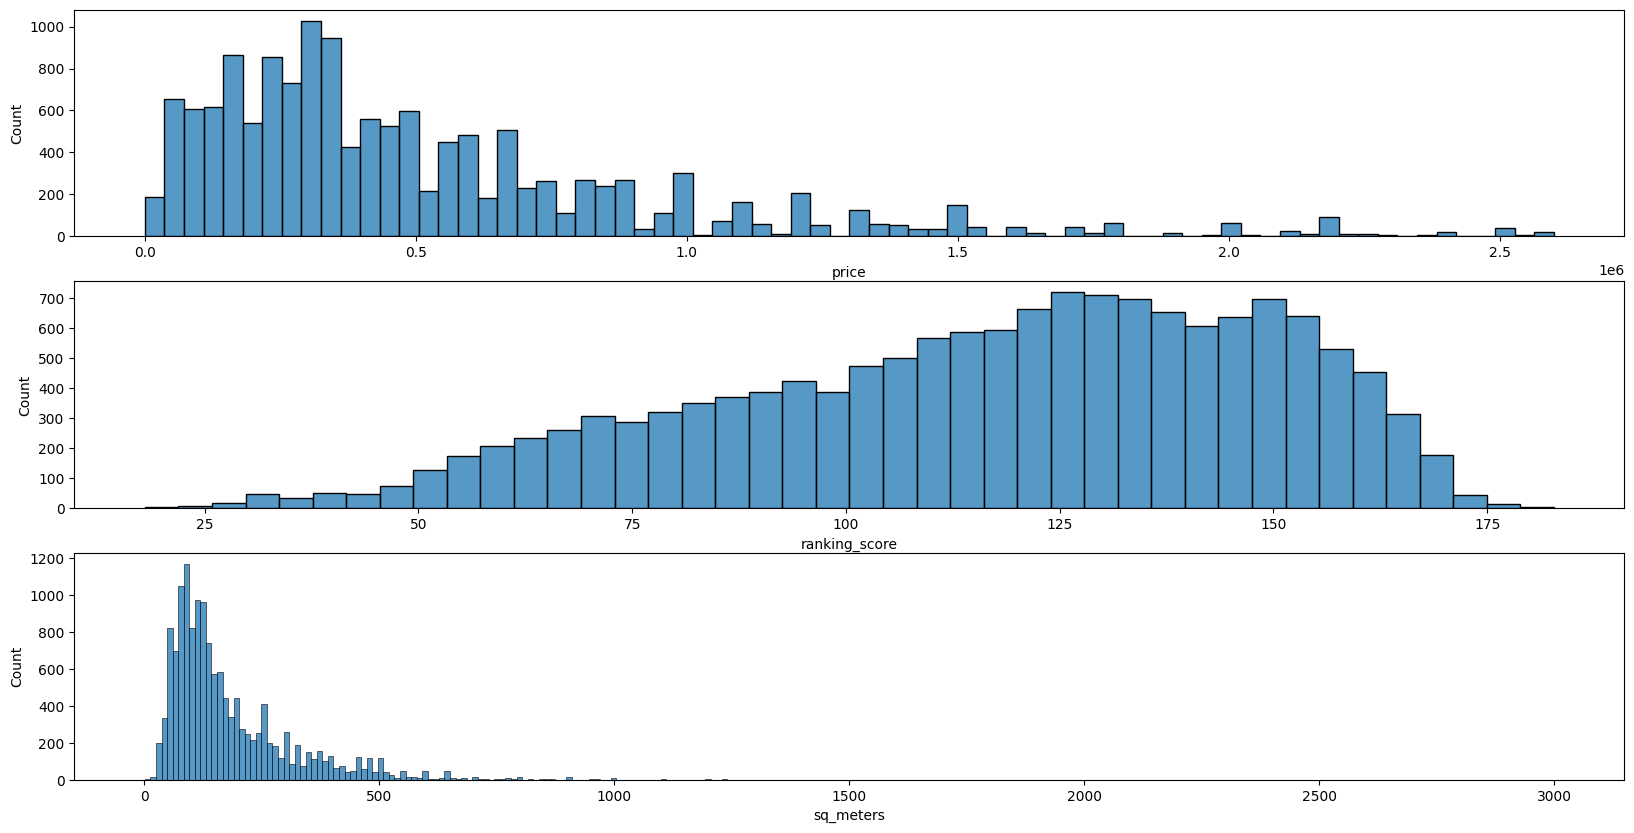

In [13]:
# Plot histograms for the numerical features

fig, ax = plt.subplots(3,1, figsize=(20,10))
sns.histplot(df['price'], ax = ax[0])
sns.histplot(df['ranking_score'], ax = ax[1])
sns.histplot(df['sq_meters'], ax = ax[2])
fig.show()

Scatter plot showing the relationship between average price and average ranking score for each area

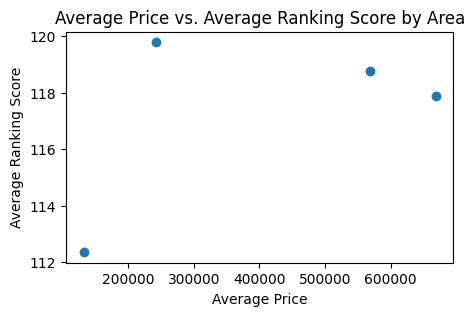

In [39]:
avg_price = df.groupby('geography_name')['price'].mean()
avg_ranking_scores = df.groupby('geography_name')['ranking_score'].mean()

plt.figure(figsize=(5,3))
scatter = plt.scatter(avg_price, avg_ranking_scores)
plt.title('Average Price vs. Average Ranking Score by Area')
plt.xlabel('Average Price')
plt.ylabel('Average Ranking Score')
plt.show()

### Part 1

**Calculate the mean, median, and standard deviation of property prices**

In [14]:
df['price'].describe()

count    1.439200e+04
mean     5.180235e+05
std      4.475298e+05
min      0.000000e+00
25%      2.250000e+05
50%      3.800000e+05
75%      6.700000e+05
max      2.600000e+06
Name: price, dtype: float64

In [15]:
df['price'].describe().round(2)

count      14392.00
mean      518023.46
std       447529.82
min            0.00
25%       225000.00
50%       380000.00
75%       670000.00
max      2600000.00
Name: price, dtype: float64

In [16]:
# by subtype
subtype_stats = df.groupby('subtype')['price'].agg(['mean', 'median', 'std']).round(2)

# by area
area_stats = df.groupby('geography_name')['price'].agg(['mean', 'median', 'std']).round(2)

# by area and subtype
stats = df.groupby(['subtype', 'geography_name'])['price'].agg(['mean', 'median', 'std']).round(2)


print("Statistics by subtype:\n", subtype_stats)
print("\nStatistics by area:\n", area_stats)
print("\nStatistics by subtype and area:\n", stats)


Statistics by subtype:
                          mean     median        std
subtype                                            
apartment           352358.03   290000.0  292769.84
apartment complex   996447.39   975000.0  556733.36
building            833295.16   665000.0  491431.14
bungalow             66500.00    66500.0    2121.32
detached            947534.65   850000.0  546956.73
loft                553272.73   369000.0  357646.78
maisonette          749111.15   620000.0  461780.81
other residential   651321.88   510000.0  485695.12
studio               57725.90    50000.0   42350.08
villa              1351260.87  1165000.0  571436.61

Statistics by area:
                           mean    median        std
geography_name                                     
beesy neighborhood   132187.87   95000.0  136837.16
gentrification area  242363.41  190000.0  234019.94
northern sub         668658.62  550000.0  437312.43
south beach          567787.88  400000.0  454765.10

Statistics by sub

**Plot property prices against subtypes and area**

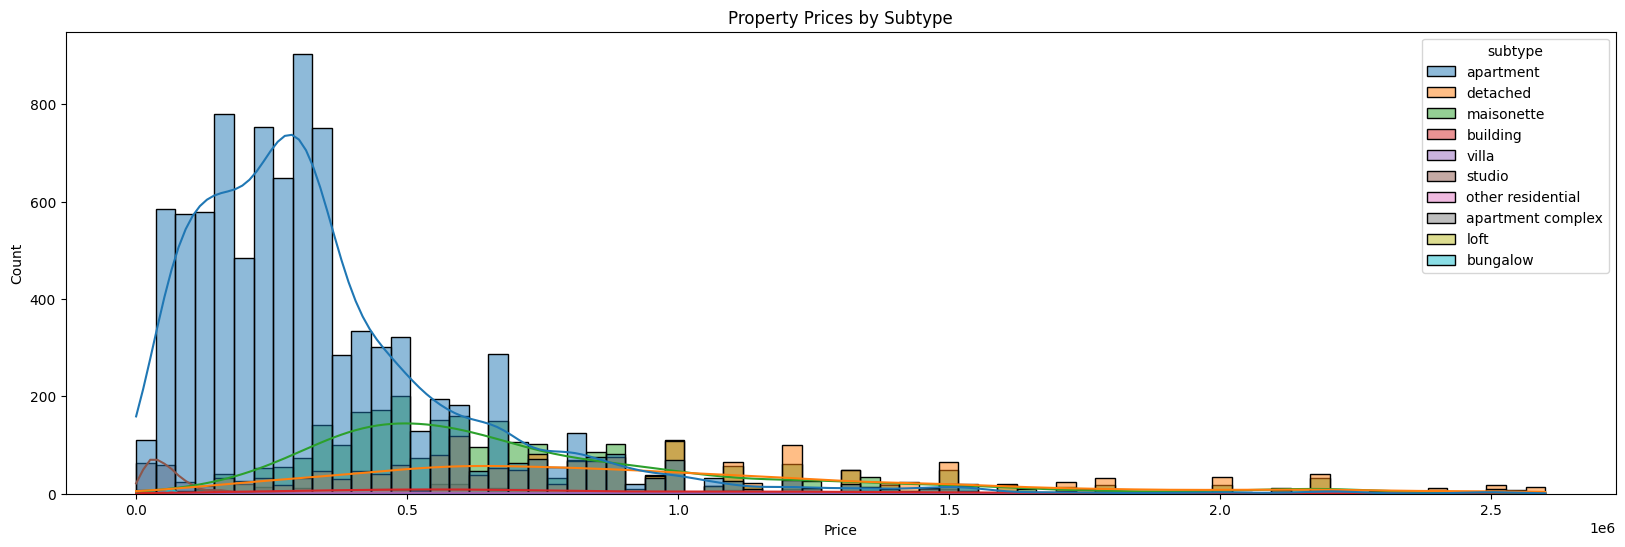

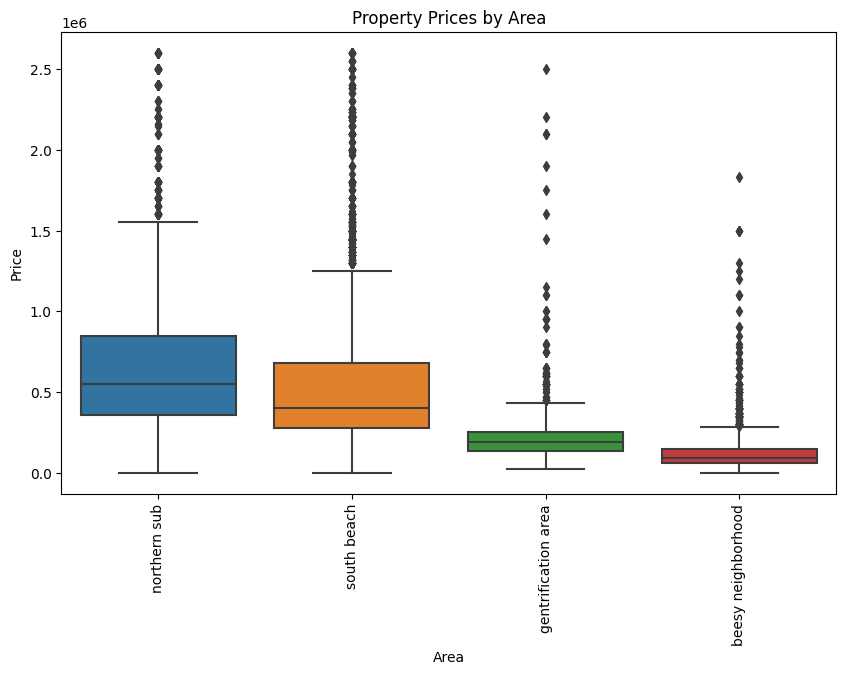

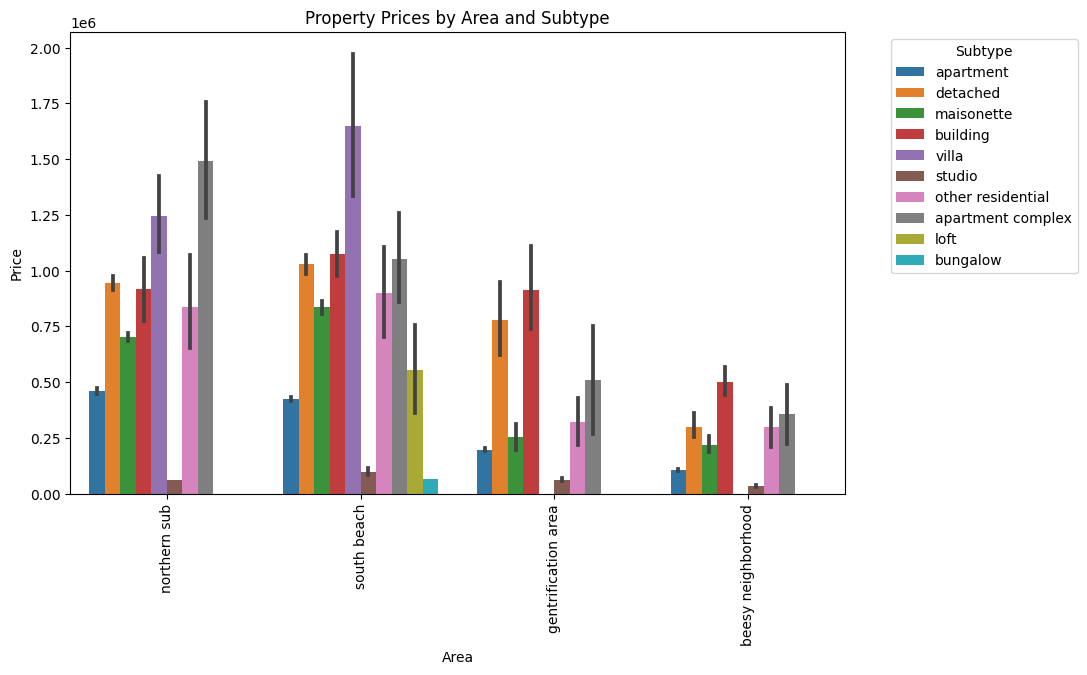

In [17]:
# histogram of property prices by subtype
plt.figure(figsize=(20,6))
sns.histplot(data=df, x='price', hue='subtype', kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Property Prices by Subtype')
plt.show()

# boxplot of property prices by area
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='geography_name', y='price')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Property Prices by Area')
plt.xticks(rotation=90)
plt.show()

# grouped barchart of property prices by area and subtype
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='geography_name', y='price', hue='subtype')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Property Prices by Area and Subtype')
plt.xticks(rotation=90)
plt.legend(title='Subtype', bbox_to_anchor=(1.05, 1))
plt.show()


**Insights generated**

There are several insights that can be drawn from the statistics presented:

- The most expensive property type on average is villa, with a mean price of 1,351,260.87 and a median of 1,165,000.00, followed by apartment complex with a mean of 996,447.39 and a median of 975,000.00.
- The cheapest type of property on average is a studio with a mean price of 57,725.90 and a median of 50,000.00.
- The subtype with the highest standard deviation in price is the villa.

- The most expensive geographic area on average is the Northern Sub with a mean price of 668,658.62 and a median of 550,000.00. The South Beach follows closely, with a mean price of 567,787.88 and a median of 400,000.00.
- The cheapest geographic area on average is Beesy Neighborhood, with a mean price of 132,187.87 and a median of 95,000.00.

Looking at the statistics by both subtype and area:

- The most expensive subtype and area combination is a villa in South Beach, with a mean price of 1,646,666.67 and a median of 1,575,000.00. An apartment complex in Northern Sub is a close second with a mean price of 1,492,857.14.

- The least expensive subtype and area combination is a studio in Beesy Neighborhood (they are also the cheapest options seperately), with a mean price of 35,835.23 and a median of 26,000.00.

- For an apartment, we can see that the average price in the Beesy Neighborhood area is much lower than the average price in the other three areas, with a mean price of 107,432.45 compared to 459,241.94 in the Northern Sub area, 423,937.50 in South Beach and 197,956.52 in the Gentrification Area. We can observe similar trends for other subtypes as well.

### Part 2

#### Competitiveness Metrics Calculations

The level of discount should be proportional to the level of competitiveness. The higher the competitiveness, the higher the discount should be.

To calculate the competitiveness metrics for each area, we can consider the following factors:

1. Number of listings: The more listings there are in an area, the more competition there is for each listing to rank high.

2. Listing quality / Ranking score distribution: If the ranking scores for listings in an area are highly concentrated around a narrow range, it indicates that it is hard for a listing to stand out and rank high. Therefore, if there are many high-quality listings in an area, it would be harder for a simple listing to rank high.

3. Price: If the prices for listings in an area are highly concentrated around a narrow range, it indicates that it is hard for a listing to stand out and rank high based on price alone.

**Number of listings**

The competitiveness metric will be a value between 0 and 1, where 1 represents the most competitive area (i.e., the area with the highest number of listings).

In [18]:
# count the number of listings in each geographic area
area_counts = df.groupby('geography_name')['id'].count().reset_index()
area_counts.rename(columns={'id': 'listing_count'}, inplace=True)

# maximum number of listings in any area
max_listings = area_counts['listing_count'].max()

# competitiveness metric
area_counts['competitiveness'] = area_counts['listing_count'] / max_listings
area_counts = area_counts.sort_values('competitiveness', ascending=False)

print(area_counts)

        geography_name  listing_count  competitiveness
3          south beach           7027         1.000000
2         northern sub           4479         0.637399
0   beesy neighborhood           2077         0.295574
1  gentrification area            809         0.115127


This method is not recommended as there could be multiple listings from different agents but of the same property. Therefore there could be a bias.

**Listing quality / Ranking score distribution**

A lower value of the CV column indicates higher competitiveness, which means that it is harder for a listing to rank high in the search results of that area just by having a high ranking score.

In [19]:
# average ranking score for each geographic area
area_avg_rank = df.groupby('geography_name')['ranking_score'].mean().reset_index()
area_avg_rank.rename(columns={"ranking_score": "mean"}, inplace=True)

# standard deviation of ranking scores for each geographic area
area_std_rank = df.groupby('geography_name')['ranking_score'].std().reset_index()
area_std_rank.rename(columns={"ranking_score": "std"}, inplace=True)

area_ranking = pd.merge(area_avg_rank, area_std_rank, on='geography_name')

# competitiveness metric
area_ranking['CV'] =  area_ranking['std'] / area_ranking['mean']
area_ranking = area_ranking.sort_values('CV', ascending=True)

print(area_ranking)

        geography_name        mean        std        CV
1  gentrification area  119.791965  30.735014  0.256570
2         northern sub  117.877517  30.337549  0.257365
3          south beach  118.757478  31.672908  0.266702
0   beesy neighborhood  112.354694  33.345401  0.296787


Based on the results of this competitiveness metric, the Gentrification Area has the lowest CV value of 0.256570, indicating the highest level of competitiveness. Therefore, by following this competitiveness metric, agents in the Gentrification Area should be given the highest discount.

On the other hand, the Northern Sub and South Beach have lower CV values of 0.257365 and 0.266702, respectively, indicating lower levels of competitiveness compared to Gentrification Area. Therefore, agents in these areas should be given lower discounts.

Finally, the Beesy Neighborhood has a CV value of 0.296787, which is the lowest, indicating the lowest level of competitiveness. Therefore, agents in this area should be given the lowest discount or even not at all.

**Price**

The competitiveness metric will be a value between 0 and 1, where 1 represents the most competitive area.

In [20]:
# total number of listings and the average price for each geographic area
area_price = df.groupby('geography_name')['price'].agg(['count', 'mean'])

# percentage difference between the average price in each area and the overall average price for all areas
area_price['price_diff'] = (area_price['mean'] - df['price'].mean()) / df['price'].mean()

# normalize the percentage difference values to be between 0 and 1
area_price['competitiveness'] = (area_price['price_diff'] - area_price['price_diff'].min()) / (area_price['price_diff'].max() - area_price['price_diff'].min())
area_price = area_price.sort_values(by='mean', ascending=False)

print(area_price)

                     count           mean  price_diff  competitiveness
geography_name                                                        
northern sub          4479  668658.622014    0.290788         1.000000
south beach           7027  567787.878753    0.096066         0.811973
gentrification area    809  242363.411619   -0.532138         0.205371
beesy neighborhood    2077  132187.867116   -0.744823         0.000000


Based on the results of this competitiveness metric, the Northern Sub has the highest level of competitiveness, following by South Beach, Gentrification Area and finally Beesy Neighborhood.

Hence, the prices for listings in Northern Sub area are the most concentrated around a narrow range, so it indicates that it is the hardest for a listing to stand out and rank high based on price alone.

Therefore, by following this competitiveness metric, agents in the Northern Sub should be given the highest discount.

#### Plots

Bar chart showing the number of listings in each area

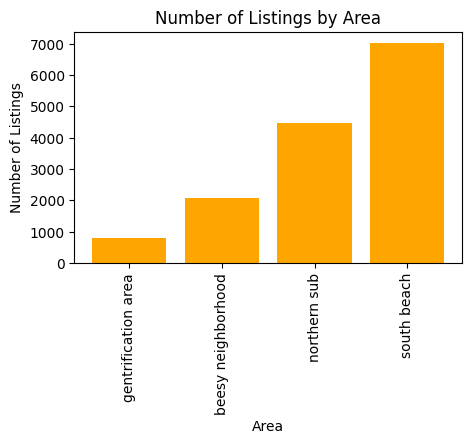

In [21]:
num_listings = df['geography_name'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(5,3))
plt.bar(num_listings.index, num_listings.values, color = 'orange')
plt.xticks(rotation=90)
plt.title('Number of Listings by Area')
plt.xlabel('Area')
plt.ylabel('Number of Listings')
plt.show()

Bar chart showing the ranking score distribution for each area

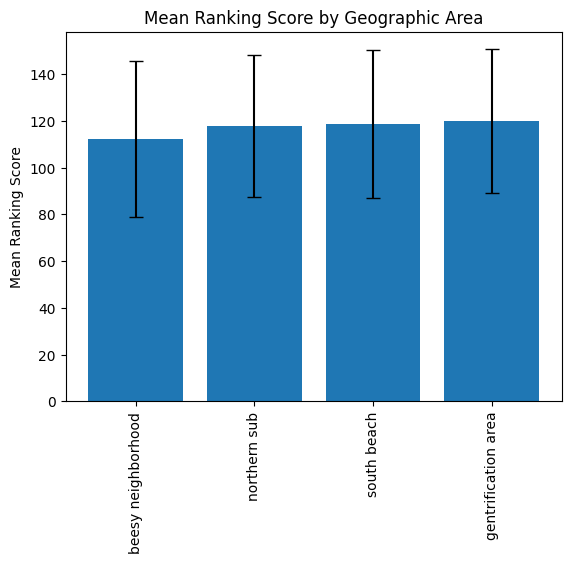

In [22]:
area_ranking = area_ranking.sort_values(by='mean', ascending=True)

plt.bar(area_ranking['geography_name'], area_ranking['mean'], yerr=area_ranking['std'], capsize=5)
plt.xticks(rotation=90)
plt.ylabel('Mean Ranking Score')
plt.title('Mean Ranking Score by Geographic Area')
plt.show()


Bar chart showing the percentage difference of price by geographic area

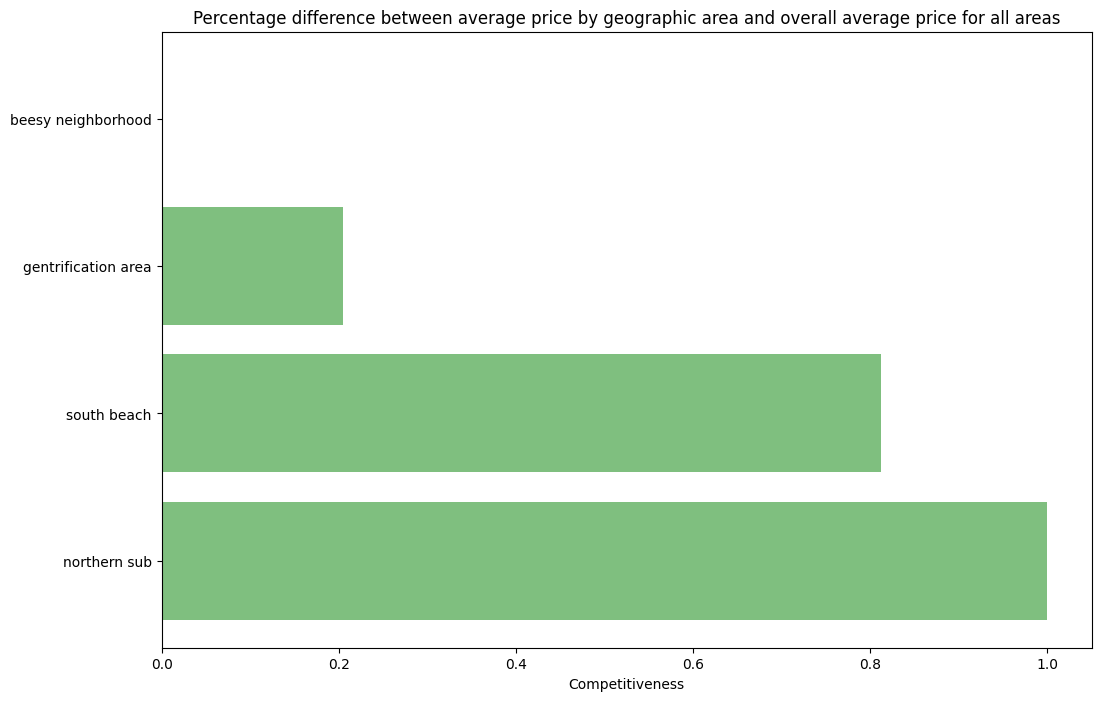

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(area_price.index, area_price['competitiveness'], color='green', alpha=0.5)
ax.set_xlabel('Competitiveness')
ax.set_title('Percentage difference between average price by geographic area and overall average price for all areas')
plt.show()

### Part 3

**Correlation**

<function matplotlib.pyplot.show(close=None, block=None)>

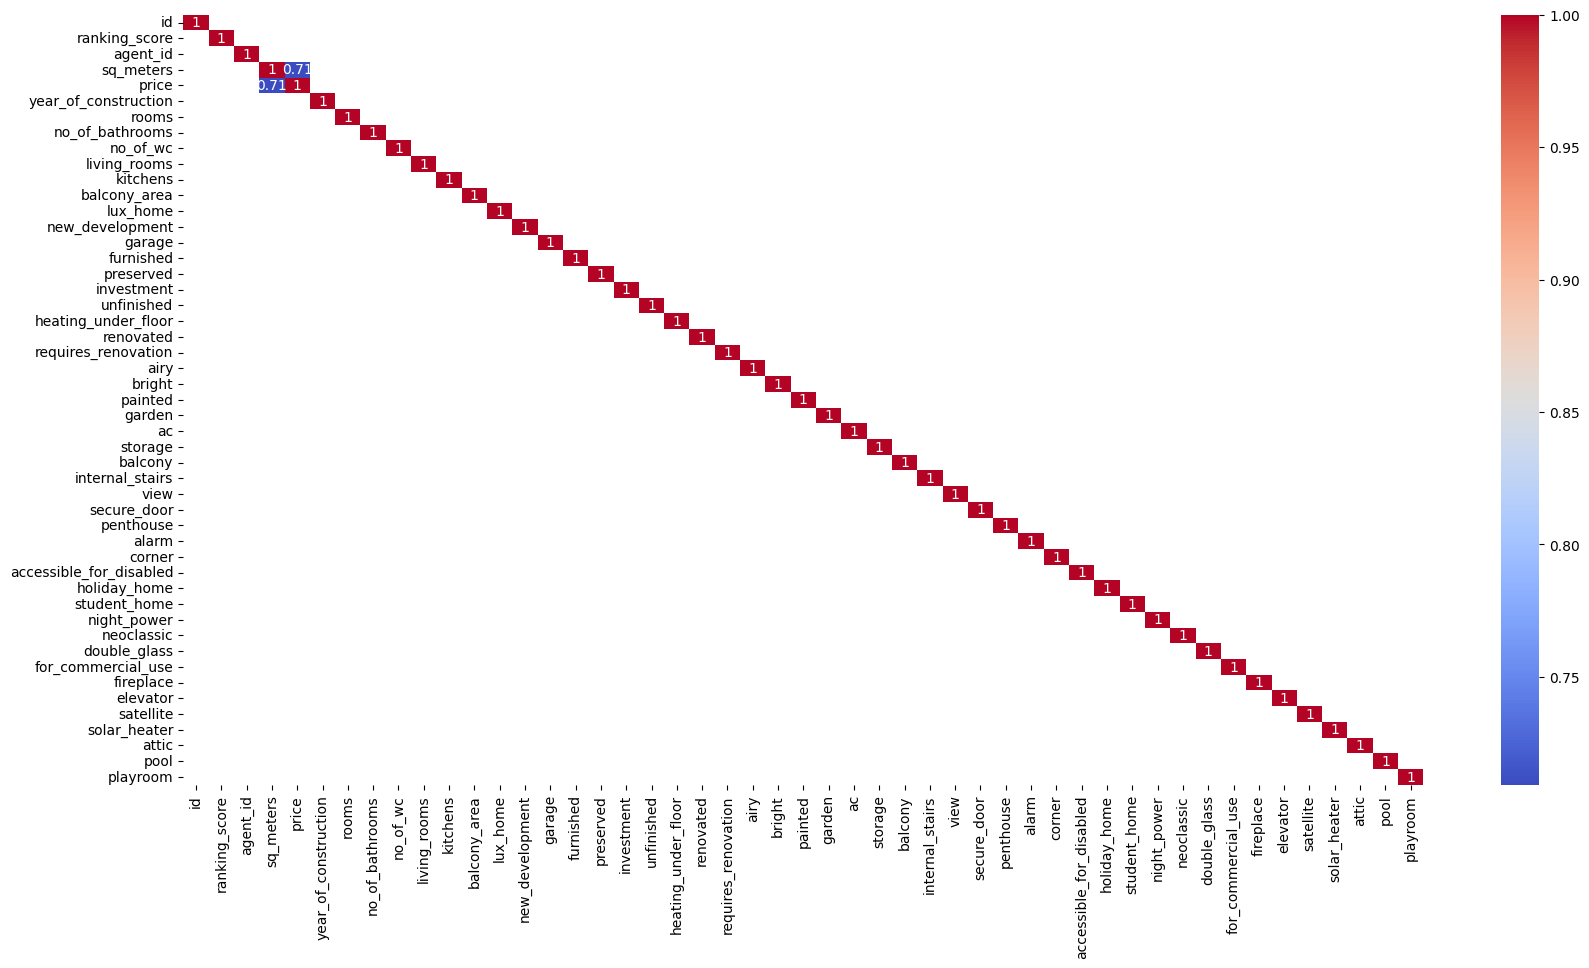

In [26]:
corr_matrix = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix[(corr_matrix >= 0.7) | (corr_matrix <= -0.7)], cmap='coolwarm', annot=True)
plt.show

**Drop Irrelevant Feautures**

In [27]:
# the id and agent_id of each property should not affect the price of the property
df.drop(columns = ['id', 'agent_id'], inplace = True)

**Identify Best Model**

In [28]:
# train-test split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define categorical and numerical columns
categorical_cols = ['geography_name', 'floor', 'subtype', 'ad_type']
numeric_cols = ['ranking_score', 'sq_meters', 'year_of_construction', 'rooms', 'no_of_bathrooms', 'no_of_wc', 'living_rooms', 'kitchens', 'balcony_area']

# preprocessing steps for the categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

In [29]:
# linear regression model
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# random forest model
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# XGBoost model
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor())
])

# evaluate the performance of the linear regression model using cross-validation
scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_lr = -1 * scores_lr.mean()
rmse_lr = np.sqrt(mse_lr)

# evaluate the performance of the Random Forest model using cross-validation
scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_rf = -1 * scores_rf.mean()
rmse_rf = np.sqrt(mse_rf)

# evaluate the performance of the XGBoost model using cross-validation
scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_xgb = -1 * scores_xgb.mean()
rmse_xgb = np.sqrt(mse_xgb)

# performance metrics
print("Linear Regression RMSE: {:.2f}".format(rmse_lr))
print("Random Forest RMSE: {:.2f}".format(rmse_rf))
print("XGBoost RMSE: {:.2f}".format(rmse_xgb))

# comparison
if rmse_lr < rmse_rf and rmse_lr < rmse_xgb:
    print("\nLinear Regression is the better model")
elif rmse_rf < rmse_lr and rmse_rf < rmse_xgb:
    print("\nRandom Forest is the better model")
else:
    print("\nXGBoost is the better model")


Linear Regression RMSE: 3797542726053819.50
Random Forest RMSE: 206433.62
XGBoost RMSE: 216936.27

Random Forest is the better model


**Most Important Attributes**

In [30]:
# fit the random forest model pipeline to the training data
pipeline_rf.fit(X_train, y_train)

# get feature importances from the fitted model
feature_importances = pipeline_rf.named_steps['model'].feature_importances_

importances_descending = sorted(zip(feature_importances, X_train.columns), reverse=True)
for importance, feature in importances_descending:
    print(f"{feature}: {importance}")

# make predictions using the pipeline
y_pred = pipeline_rf.predict(X_test)


alarm: 0.6511176422440128
corner: 0.10257803559916434
penthouse: 0.04423137646427973
year_of_construction: 0.03069552001008732
ranking_score: 0.02537391206847241
accessible_for_disabled: 0.01907463896983647
holiday_home: 0.018030206384296536
ad_type: 0.016090553809738704
student_home: 0.011392261967607042
airy: 0.010632342673613302
sq_meters: 0.00890363677812352
painted: 0.008244403521669812
neoclassic: 0.0074356611572711315
night_power: 0.007073475547720951
unfinished: 0.00653577990447342
double_glass: 0.006334159243558421
furnished: 0.005578679250548478
no_of_bathrooms: 0.005402406742725172
living_rooms: 0.002581534262580714
floor: 0.0025113124999823805
renovated: 0.0017299688863354967
preserved: 0.0011691122915665506
view: 0.0009801078975079432
kitchens: 0.0008954706831455208
internal_stairs: 0.0008756989382023429
storage: 0.0008396986110798359
garage: 0.0008265294585729079
balcony: 0.000628046105218916
geography_name: 0.0005577758797339551
garden: 0.00045887262083552793
secure_door

As per the model, the most important feature is that the property has an alarm, hence if it could be considered safe.

The top five features are:
1. alarm
2. corner
3. penthouse
4. year_of_construction
5. ranking_score